<a href="https://colab.research.google.com/github/Temmy-bit/Advance-Pytorch/blob/main/slide_and_seek_classification_for_landslide_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

arc_prize_2025_path = kagglehub.competition_download('arc-prize-2025')
muhammadqasimshabbir_slideandseekclasificationlandslidedetectiondataset_path = kagglehub.dataset_download('muhammadqasimshabbir/slideandseekclasificationlandslidedetectiondataset')

print('Data source import complete.')


Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0
Test.csv:
          ID
0  ID_ICB8K9
1  ID_2D4AOJ
2  ID_2TVPI0
3  ID_E05WIK
4  ID_KKFDJO


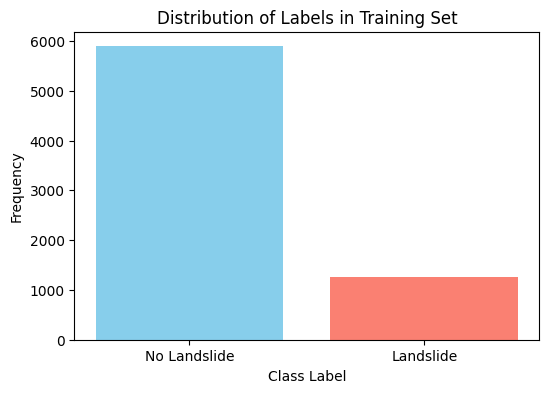

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
data = "/kaggle/input/slideandseekclasificationlandslidedetectiondataset"

# Define paths for the dataset (remember to unzip the dataset first!)
train_csv_path = f'{data}/Train.csv'  # Path to the training labels CSV file
test_csv_path = f'{data}/Test.csv'    # Path to the test image IDs CSV file
train_data_path = f'{data}/train_data'  # Folder where .npy train files are located
test_data_path = f'{data}/test_data'    # Folder where .npy test files are located

# # Load Train.csv and inspect the data
train_df = pd.read_csv(train_csv_path)
print("Train.csv:")
print(train_df.head())

# # Load Test.csv and inspect the data
test_df = pd.read_csv(test_csv_path)
print("Test.csv:")
print(test_df.head())

train_df.label.value_counts()

# Check distribution of labels
label_counts = train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']  # Map the labels 0 and 1 to descriptive names

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()



In [ ]:
X = train_df.drop('label',axis=1)
y = train_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
y_train.value_counts()

label
0    4397
1     963
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

label
0    1495
1     292
Name: count, dtype: int64

In [ ]:
!nvidia-smi

Tue Jul 15 08:10:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
train_2, test_2 = train_test_split(train_df,test_size=0.3)

In [ ]:
test_2.head()

,ID,label
955,ID_I9YJZ1,1
1652,ID_OCH16K,0
4137,ID_4ZT8P4,0
2367,ID_UWYQ0J,0
4580,ID_H966FN,0


In [ ]:
train_2.head()

,ID,label
6261,ID_1AXXTZ,0
3782,ID_ON7F56,0
3331,ID_6BM9M9,0
5347,ID_HS3RBB,1
5125,ID_Z14XE6,0


In [ ]:
train_2['label'].value_counts()

label
0    4103
1     899
Name: count, dtype: int64

In [ ]:
test_2['label'].value_counts()

label
0    1789
1     356
Name: count, dtype: int64

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

class LabeledNpyDataset(Dataset):
    def __init__(self, dataframe, features_dir, transform=None,train=False):
        self.df = dataframe.reset_index(drop=True)
        self.features_dir = features_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.loc[idx, 'ID']+'.npy'
        if self.train == True:
            label = self.df.loc[idx, 'label']
            # print(file_name,label)
            y = torch.tensor(label, dtype=torch.float32)

        else:
            y=0

        # Load .npy file
        feature_path = os.path.join(self.features_dir, file_name)
        x = np.load(feature_path)
        # print(x)
        # x = torch.tensor(x, dtype=torch.float32)

        if self.transform:
            x = self.transform(x)

        else:
            x = torch.tensor(x, dtype=torch.float32)

        # y = torch.tensor(label, dtype=torch.long)
        return x, y


In [ ]:
import numpy as np
import torch

class CustomAugmentation:
    def __init__(self, normalize=True, flip=True, rotate=True):
        self.normalize = normalize
        self.flip = flip
        self.rotate = rotate

    def __call__(self, x):  # x is a NumPy array (64, 64, 12)
        # Horizontal flip
        if self.flip and np.random.rand() < 0.5:
            x = np.flip(x, axis=1)

        # Rotation
        if self.rotate and np.random.rand() < 0.5:
            k = np.random.randint(0, 4)
            x = np.rot90(x, k, axes=(0, 1))

        # Normalize per channel
        if self.normalize:
            x = x.astype(np.float32)
            x = (x - np.mean(x, axis=(0, 1))) / (np.std(x, axis=(0, 1)) + 1e-7)

        # Convert to PyTorch Tensor (C, H, W)
        x = torch.tensor(x).permute(2, 0, 1).float()
        return x


In [ ]:
from torchvision import transforms

data_transform = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5,0.5, 0.5, 0.5,0.5, 0.5, 0.5,0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5,0.5, 0.5, 0.5,0.5, 0.5, 0.5,0.5, 0.5, 0.5))
])


In [ ]:
data_transform(np.random.rand(64,64,12)).shape

torch.Size([12, 64, 64])

In [ ]:
# from albumentations.pytorch import ToTensorV2
# import albumentations as A

# # Define transform
# data_transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Rotate(limit=15, p=0.5),
#     A.Normalize(),
#     ToTensorV2()
# ])

In [ ]:
np.load('/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data/ID_005GY8.npy').shape

(64, 64, 12)

In [ ]:
example_ids = train_df['ID'].sample(2).values  # Randomly select 2 image IDs for illustration
print(train_df[train_df['ID'].isin(example_ids)]['label'])
print(example_ids)

4326    0
4720    0
Name: label, dtype: int64
['ID_R56VG9' 'ID_LEH99I']


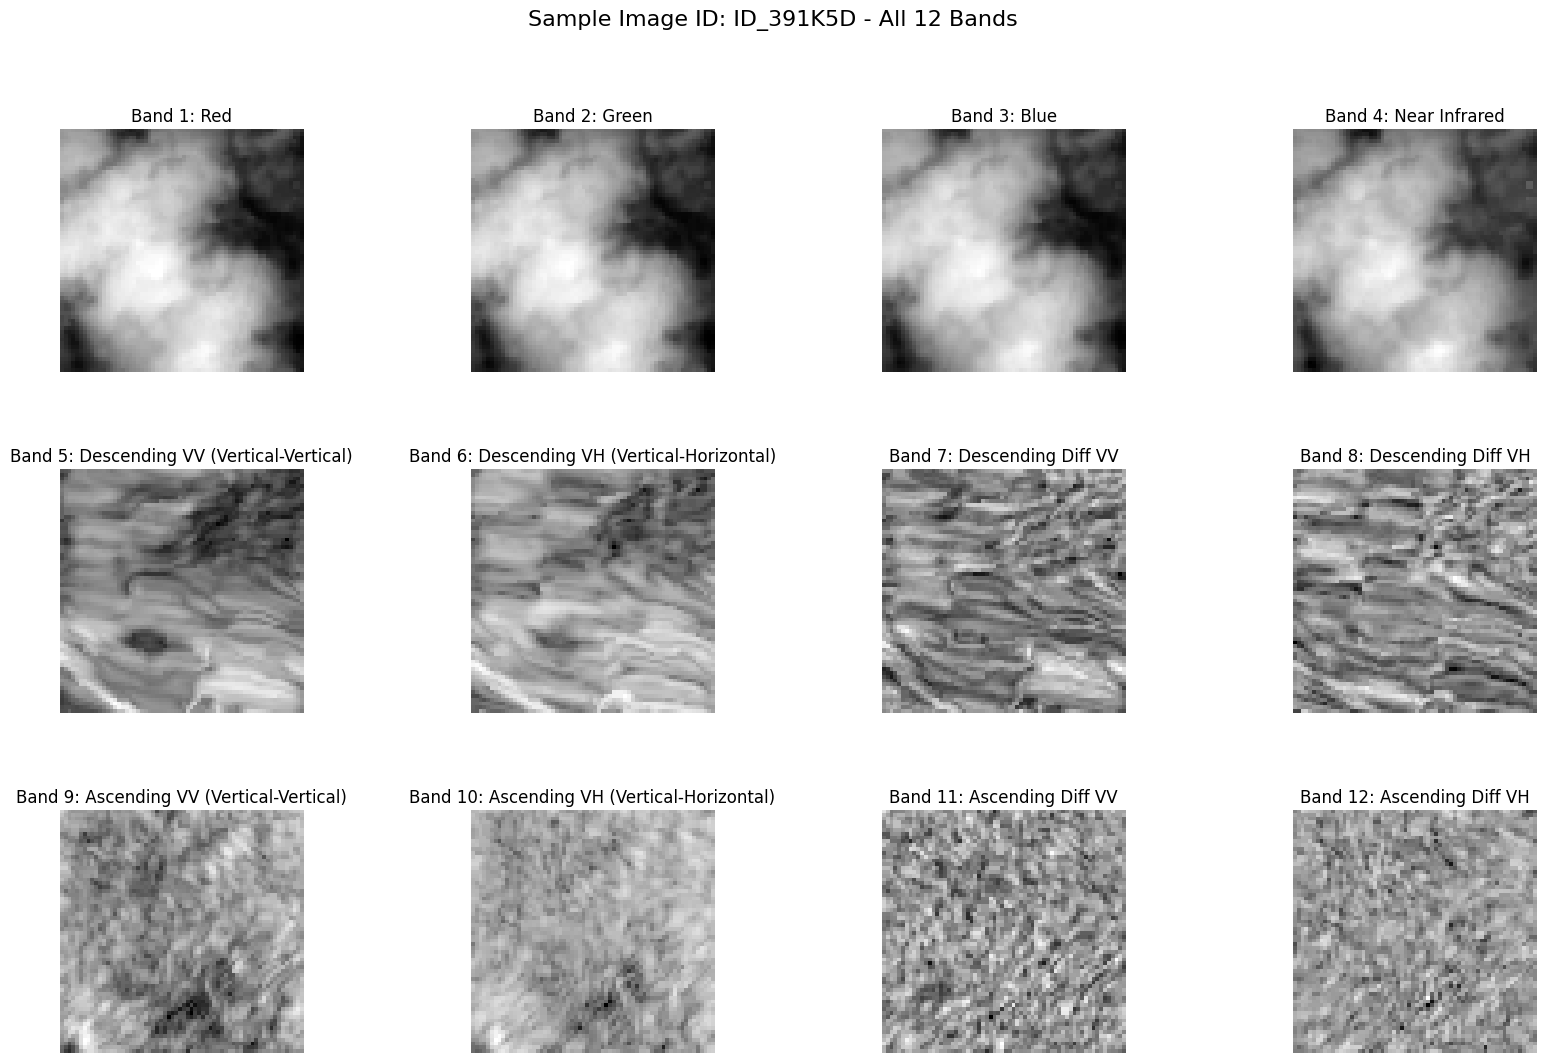

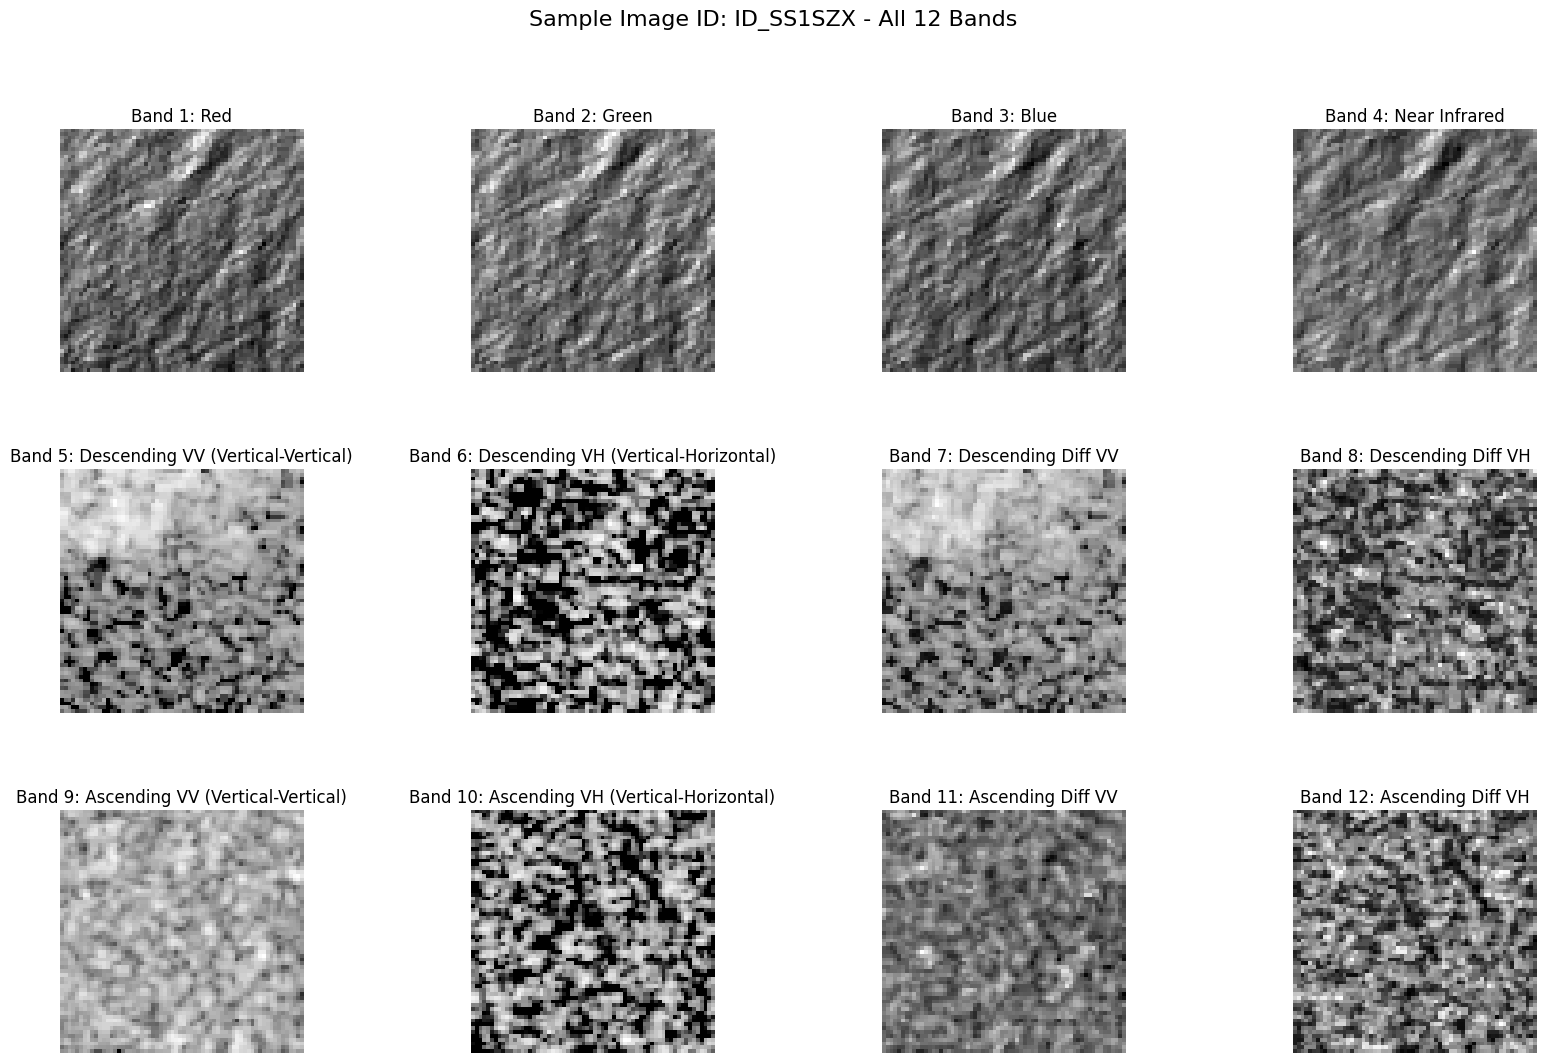

In [ ]:
# img = cv2.imread("img",torch.tensor(np.load('/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data/ID_005GY8.npy')))

img = np.load('/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data/ID_007CM8.npy')

def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    folder_path = '/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data/'
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)

    # Normalize each band to the 0-1 range
    img_normalized = (img - img.min(axis=(0, 1))) / (img.max(axis=(0, 1)) - img.min(axis=(0, 1)) + 1e-5)
    return img_normalized

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Displaying a few example images with all 12 bands
example_ids = train_df['ID'].sample(2).values  # Randomly select 2 image IDs for illustration

for image_id in example_ids:
    img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

    # Plot all 12 bands in a 3x4 grid
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3 rows, 4 columns for 12 plots
    fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands", fontsize=16)

    # Display each of the 12 bands with descriptions
    for band in range(12):
        row = band // 4  # Calculate row index (0, 1, or 2)
        col = band % 4   # Calculate column index (0 to 3)
        axes[row, col].imshow(img_normalized[:, :, band], cmap='gray')
        axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")
        axes[row, col].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between plots
    plt.show()

In [ ]:
# # Randomly select 2 sample IDs
# example_ids = train_df['ID'].sample(2).values

# for image_id in example_ids:
#     img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

#     # Get numeric label and mapped text label
#     label_value = train_df.loc[train_df['ID'] == image_id, 'label'].values[0]
#     label_text = label_mapping[label_value]

#     # Plot all 12 bands
#     fig, axes = plt.subplots(3, 4, figsize=(20, 12))
#     fig.suptitle(f"Image ID: {image_id} - Label: {label_text}", fontsize=16)

#     for band in range(12):
#         row = band // 4
#         col = band % 4
#         axes[row, col].imshow(img_normalized[:, :, band])
#         axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")
#         axes[row, col].axis('off')

#     plt.subplots_adjust(wspace=0.3, hspace=0.4)
#     plt.show()

In [ ]:
# # Randomly select 2 sample IDs
# example_ids = train_df['ID'].sample(2).values

# for image_id in example_ids:
#     img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

#     # Get numeric label and mapped text label
#     label_value = train_df.loc[train_df['ID'] == image_id, 'label'].values[0]
#     label_text = label_mapping[label_value]

#     # Plot all 12 bands
#     fig, axes = plt.subplots(3, 4, figsize=(20, 12))
#     fig.suptitle(f"Image ID: {image_id} - Label: {label_text}", fontsize=16)

#     for band in range(12):
#         row = band // 4
#         col = band % 4
#         axes[row, col].imshow(img_normalized[:, :, band], cmap='gray')
#         axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")
#         axes[row, col].axis('off')

#     plt.subplots_adjust(wspace=0.3, hspace=0.4)
#     plt.show()


Image shape: (64, 64, 12)


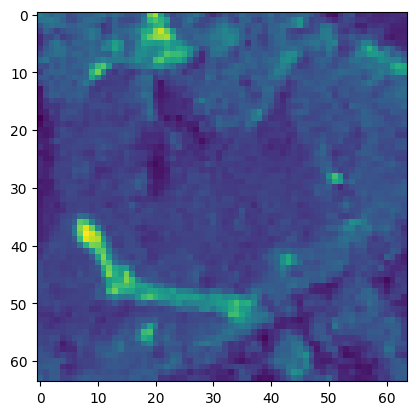

In [ ]:
# img, label = next(iter(train_loader))
plt.imshow(torch.tensor(img).permute([2,1,0])[0])
print(f"Image shape: {img.shape}")
# print(f"Image classes {image_classes}")
# print(f"label {label[0]}")

In [ ]:
train_df.loc[0]

ID       ID_HUD1ST
label            1
Name: 0, dtype: object

In [ ]:
train_dataset = LabeledNpyDataset(train_2,'/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data',data_transform,train=True)
__,_ = train_dataset[1]
print(__.shape,_)

torch.Size([12, 64, 64]) tensor(0.)


In [ ]:
test_dataset = LabeledNpyDataset(test_2,'/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data/',data_transform,train=True)
__,_ = test_dataset[1]
print(__.shape,_)

torch.Size([12, 64, 64]) tensor(0.)


In [ ]:
len(train_dataset),len(test_dataset)

(5002, 2145)

In [ ]:
train_df.head()

,ID,label
0,ID_HUD1ST,1
1,ID_KGE2HY,1
2,ID_VHV9BL,1
3,ID_ZT0VEJ,0
4,ID_5NFXVY,0


In [ ]:
from torch.utils.data import WeightedRandomSampler
import numpy as np
import torch

# Step 1: Get class counts
class_counts = train_2['label'].value_counts().to_dict()

# Step 2: Assign weights
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_2['label']]

# Step 2: Assign weights
test_class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
test_sample_weights = [class_weights[label] for label in test_2['label']]

# Step 3: Create sampler
sampler = WeightedRandomSampler(weights=sample_weights,
                                 num_samples=len(sample_weights),
                                 replacement=True)

# Step 3: Create sampler
test_sampler = WeightedRandomSampler(weights=test_sample_weights,
                                 num_samples=len(test_sample_weights),
                                 replacement=True)

# # Step 4: Use in DataLoader
# train_dataloader = DataLoader(train_dataset,
#                               batch_size=BATCH_SIZE,
#                               sampler=sampler)

In [ ]:
from torch.utils.data import DataLoader

# setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (Batches)
train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size = BATCH_SIZE,
                              # sampler=sampler,
                             )

test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size = BATCH_SIZE,
                             )

In [ ]:
train_features_batch,train_label_batch = next(iter(train_dataloader))
train_features_batch.shape, train_label_batch.shape

(torch.Size([32, 12, 64, 64]), torch.Size([32]))

In [ ]:
test_features_batch,test_label_batch = next(iter(test_dataloader))
test_features_batch.shape, test_label_batch.shape

(torch.Size([32, 12, 64, 64]), torch.Size([32]))

In [ ]:
import torch.nn as nn

In [ ]:
class SlideSeekModelV0(nn.Module):
    def __init__(self,in_channels : int,
                # hidden_units : int,
                out_channels : int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, padding=1),
            nn.relu()


        )
    def forward(self,x):
        return self.layer_stack(x)


In [ ]:
class SlideSeekModel01(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1 ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     padding=1,
                     stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     padding=1,
                     stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                     out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        # print(f"Output shape for the first conv block {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output of the second conv block {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape for the classfier conv block {x.shape}")
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
torch.manual_seed(42)
model_1=SlideSeekModel01(input_shape  = 12,
                    hidden_units = 10,
                    output_shape = 2).to(device)

class_counts = train_2['label'].value_counts().sort_index()
weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
weights = weights / weights.sum()  # Normalize (optional)

loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),lr=0.001)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LandslideCNN(nn.Module):
    def __init__(self, num_classes):
        super(LandslideCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)  # downsample from 64x64 → 32x32

        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (B, 32, 32, 32)
        # print(x.shape)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (B, 64, 16, 16)
        # print(x.shape)

        x = x.view(x.size(0), -1)  # flatten for FC
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x)
        return x


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
64*64*12

49152

In [ ]:
model_2 = LandslideCNN(num_classes=2).to(device)
# loss_fn = nn.CrossEntropyLoss()
class_counts = train_2['label'].value_counts().sort_index()
weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
weights = weights / weights.sum()  # Normalize (optional)

loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model_1.parameters(),lr=0.001)
optimizer = torch.optim.Adam(params = model_2.parameters(),lr=0.001)

In [ ]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [ ]:
dummy_x = torch.rand([1, 12, 64, 64]).to(device)
model_2(dummy_x)

tensor([[-0.4868,  0.1015]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)

epochs = 20
def run_model(model_2,epochs,train_dataloader=train_dataloader,test_dataloader = test_dataloader):
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n-----")
        train_acc = 0
        for batch, (X,y) in enumerate(train_dataloader):
            # X = X.torch
            X = X.float().to(device)   # Force float32
            y = y.long().to(device)

            model_2.train()
            y_pred = model_2(X)

            loss=loss_fn(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss /= len(train_dataloader)
            acc  = accuracy_fn(y,y_pred.argmax(dim=1))
            train_acc += acc

            model_2.eval()
            test_ac = 0
            with torch.inference_mode():
                for X_test,y_test in test_dataloader:
                    X_test = X_test.float().to(device)
                    y_test = y_test.long().to(device)
                    test_pred = model_2(X_test)
                    test_loss = loss_fn(test_pred,y_test)
                    test_acc = accuracy_fn(y_test,test_pred.argmax(dim=1))
                    test_ac += test_acc

                test_ac /= len(test_dataloader)
            train_acc /= len(train_dataloader)

        print(f"Train accuracy {train_acc:.4f}| Train loss {loss:.4f}| Test accuracy {test_ac:.4f}| Test Loss {test_loss:.4f}")

    return y_pred


In [1]:
# torch.manual_seed(42)
# model_3=SlideSeekModelV0(12,2).to(device)

# class_counts = train_2['label'].value_counts().sort_index()
# weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
# weights = weights / weights.sum()  # Normalize (optional)

# loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

# # loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model_1.parameters(),lr=0.001)

In [ ]:
train_dataset = LabeledNpyDataset(train_df,'/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data',data_transform,train=True)
__,_ = train_dataset[1]
print(__.shape,_)

In [ ]:
model_2_output = run_model(model_2,epochs=5)
model_2_pred = model_test(model_2,'model2_weight_one.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.5764| Train loss 0.0039| Test accuracy 77.2518| Test Loss 0.6061
Epoch: 1
-----
Train accuracy 0.5127| Train loss 0.0032| Test accuracy 74.8162| Test Loss 0.6246
Epoch: 2
-----
Train accuracy 0.5129| Train loss 0.0029| Test accuracy 67.7390| Test Loss 1.0331
Epoch: 3
-----
Train accuracy 0.5766| Train loss 0.0023| Test accuracy 80.9283| Test Loss 0.0735
Epoch: 4
-----
Train accuracy 0.4497| Train loss 0.0038| Test accuracy 77.7114| Test Loss 0.4479


In [ ]:
model_2_output = run_model(model_2,epochs=5)
model_2_pred = model_test(model_2,'model2_weight2.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.5127| Train loss 0.0035| Test accuracy 49.7243| Test Loss 0.8289
Epoch: 1
-----
Train accuracy 0.5767| Train loss 0.0023| Test accuracy 74.8162| Test Loss 0.5927
Epoch: 2
-----
Train accuracy 0.5763| Train loss 0.0019| Test accuracy 71.9210| Test Loss 0.6578
Epoch: 3
-----
Train accuracy 0.5129| Train loss 0.0021| Test accuracy 78.3548| Test Loss 0.1145
Epoch: 4
-----
Train accuracy 0.5130| Train loss 0.0024| Test accuracy 72.9779| Test Loss 1.3422


NameError: name 'model_test' is not defined

In [ ]:
model_2_pred = model_test(model_2,'model2_weight2.csv')

In [ ]:
run_model(model_1,epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.5753| Train loss 0.0027| Test accuracy 18.3824| Test Loss 0.0000
Epoch: 1
-----
Train accuracy 0.3205| Train loss 0.0222| Test accuracy 18.3824| Test Loss 0.0000
Epoch: 2
-----
Train accuracy 0.4476| Train loss 0.0232| Test accuracy 18.3824| Test Loss 0.0000
Epoch: 3
-----
Train accuracy 0.2568| Train loss 0.0229| Test accuracy 18.3824| Test Loss 0.0000
Epoch: 4
-----
Train accuracy 0.3850| Train loss 0.0124| Test accuracy 18.3824| Test Loss 0.0000


In [ ]:
run_model(model_2,epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.3848| Train loss 0.0049| Test accuracy 63.0515| Test Loss 0.6005
Epoch: 1
-----
Train accuracy 0.3851| Train loss 0.0037| Test accuracy 65.9007| Test Loss 0.1518
Epoch: 2
-----
Train accuracy 0.5767| Train loss 0.0012| Test accuracy 74.5864| Test Loss 0.1616
Epoch: 3
-----
Train accuracy 0.4494| Train loss 0.0024| Test accuracy 69.4853| Test Loss 0.1238
Epoch: 4
-----
Train accuracy 0.5127| Train loss 0.0020| Test accuracy 66.5901| Test Loss 5.3811


In [ ]:
run_model(model_2,epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.3843| Train loss 0.0027| Test accuracy 70.8180| Test Loss 0.3608
Epoch: 1
-----
Train accuracy 0.5121| Train loss 0.0018| Test accuracy 77.3438| Test Loss 0.1563
Epoch: 2
-----
Train accuracy 0.5764| Train loss 0.0016| Test accuracy 60.8456| Test Loss 5.0500
Epoch: 3
-----
Train accuracy 0.5768| Train loss 0.0008| Test accuracy 54.0441| Test Loss 0.0439
Epoch: 4
-----
Train accuracy 0.5767| Train loss 0.0003| Test accuracy 80.6526| Test Loss 1.8509


In [ ]:
run_model(model_2,epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.2563| Train loss 0.0041| Test accuracy 43.2445| Test Loss 0.4695
Epoch: 1
-----
Train accuracy 0.3842| Train loss 0.0031| Test accuracy 68.1066| Test Loss 0.3706
Epoch: 2
-----
Train accuracy 0.5124| Train loss 0.0021| Test accuracy 72.5643| Test Loss 0.2175
Epoch: 3
-----
Train accuracy 0.5757| Train loss 0.0017| Test accuracy 63.4191| Test Loss 0.2706
Epoch: 4
-----
Train accuracy 0.5759| Train loss 0.0014| Test accuracy 77.7574| Test Loss 0.0490


tensor([[ 1.1152, -2.8256],
        [ 0.5708, -1.4399],
        [ 2.5050, -3.1740],
        [-0.7457,  1.9641],
        [ 0.1606, -0.1010],
        [ 4.5051, -5.1178],
        [-0.4670,  1.3538],
        [-0.7429,  1.9411],
        [ 0.0405, -0.4604],
        [ 1.1630, -2.5873]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
model_test(model_2,'test.csv')

NameError: name 'model_test' is not defined

In [ ]:
in_channel = 12
num_classes = 2
learning_rate = 0.001
batch_size = 64
num_epochs = 5

In [ ]:
model_4 = torchvision.models.resnet18(pretrained=False).to(device)
# model.features[0] = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(3,3)).to(device)
model_4.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)
# nn.Conv2d()
# print(model)
# model_4.avgpool = Identity().to(device)
# model.classifier[0] = nn.Linear(512,10)

# for adding multiple layer with nn.Sequential
model_4.fc = nn.Sequential(nn.Linear(512,100),
                                 nn.Linear(100,2)).to(device)

# for i in range(1,7):
#     model.classifier[i] = Identity()
# print(model_4)

# sys.exit()
# model = NN(input_size=input_size,num_classes=num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(),lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=3,verbose =True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3,
    steps_per_epoch=len(train_dataloader),
    epochs=5
)

In [ ]:
run_model(model_4,epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.3851| Train loss 0.0042| Test accuracy 84.9724| Test Loss 0.2605
Epoch: 1
-----
Train accuracy 0.5766| Train loss 0.0011| Test accuracy 85.0643| Test Loss 0.0144
Epoch: 2
-----
Train accuracy 0.5769| Train loss 0.0040| Test accuracy 55.4228| Test Loss 0.0015
Epoch: 3
-----
Train accuracy 0.5771| Train loss 0.0021| Test accuracy 90.6250| Test Loss 0.0093
Epoch: 4
-----
Train accuracy 0.4492| Train loss 0.0054| Test accuracy 85.5699| Test Loss 0.0014


In [ ]:
run_model(model_4,epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.4488| Train loss 0.0025| Test accuracy 71.8290| Test Loss 0.2579
Epoch: 1
-----
Train accuracy 0.5130| Train loss 0.0019| Test accuracy 80.6066| Test Loss 0.0408
Epoch: 2
-----
Train accuracy 0.6405| Train loss 0.0012| Test accuracy 81.2040| Test Loss 0.3041
Epoch: 3
-----
Train accuracy 0.4498| Train loss 0.0039| Test accuracy 82.3070| Test Loss 0.7793
Epoch: 4
-----
Train accuracy 0.6408| Train loss 0.0009| Test accuracy 84.8805| Test Loss 0.0909


In [ ]:
run_model(model_4,epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.5763| Train loss 0.0013| Test accuracy 72.8401| Test Loss 0.0010
Epoch: 1
-----
Train accuracy 0.5763| Train loss 0.0013| Test accuracy 72.8401| Test Loss 0.0010
Epoch: 2
-----
Train accuracy 0.5763| Train loss 0.0013| Test accuracy 72.8401| Test Loss 0.0010
Epoch: 3
-----
Train accuracy 0.5763| Train loss 0.0013| Test accuracy 72.8401| Test Loss 0.0010
Epoch: 4
-----
Train accuracy 0.5763| Train loss 0.0013| Test accuracy 72.8401| Test Loss 0.0010


tensor([[ 3.1341, -3.0071],
        [-1.6883,  1.3590],
        [ 2.4748, -2.0348],
        [-5.4089,  4.2305],
        [ 0.9712, -0.8652],
        [ 3.2087, -2.7651],
        [ 0.6267, -0.5478],
        [-3.8849,  3.2819],
        [ 1.4933, -1.7984],
        [ 1.6568, -1.6708]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
testing = model_test(model_4,'model_4again.csv')

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.iloc[idx]['ID'] + '.npy'
        file_path = os.path.join(self.data_dir, file_name)
        image = np.load(file_path)  # shape: (64, 64, 12)

        # Convert to torch tensor and permute to (C, H, W)
        image = torch.from_numpy(image).float().permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
test = TestDataset(test_df,"/kaggle/input/slideandseekclasificationlandslidedetectiondataset/test_data/test_data")
len(test)

5398

In [ ]:
next(iter(test)).shape

torch.Size([12, 64, 64])

In [ ]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [ ]:
def model_test(model,sub_name):
    all_preds = []

    with torch.no_grad():
        model.eval()
        for batch in test_loader:
            batch = batch.to(device)
            logits = model(batch)  # shape: [BATCH_SIZE, NUM_CLASSES]
            predicted_labels = torch.argmax(logits, dim=1)  # take max class index
            all_preds.extend(predicted_labels.cpu().numpy())
    # print(all_preds)
    test_df['label'] = all_preds
    test_df[['ID', 'label']].to_csv(sub_name, index=False)
    return all_preds

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
classification_report(y_pred,y)

NameError: name 'y_pred' is not defined

In [ ]:
model_5

EfficientNet(
  (features): Sequential(
    (0): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
model_5 = torchvision.models.efficientnet_b0(weights=None).to(device)
# model.features[0] = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=(3,3)).to(device)
model_5.features[0] = nn.Conv2d(12, 32, kernel_size=7, stride=2, padding=3, bias=False).to(device)
model_5.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters(),lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=3,verbose =True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3,
    steps_per_epoch=len(train_dataloader),
    epochs=5
)

In [ ]:
run_model(model_5,epochs= 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Train accuracy 0.2568| Train loss 0.0041| Test accuracy 75.6893| Test Loss 0.8412
Epoch: 1
-----
Train accuracy 0.4485| Train loss 0.0039| Test accuracy 74.3107| Test Loss 0.8040
Epoch: 2
-----
Train accuracy 0.2582| Train loss 0.0044| Test accuracy 73.9890| Test Loss 0.7300
Epoch: 3
-----
Train accuracy 0.2576| Train loss 0.0051| Test accuracy 72.4265| Test Loss 0.7425
Epoch: 4
-----
Train accuracy 0.5121| Train loss 0.0027| Test accuracy 73.7132| Test Loss 0.8549


tensor([[-0.1121,  0.1740],
        [-0.7308,  0.7404],
        [-0.3919,  0.9396],
        [ 0.4140,  0.0521],
        [-0.4972,  0.7555],
        [ 1.5258, -1.7054],
        [-0.1407,  0.2255],
        [ 0.5109, -0.4742],
        [ 1.5356, -1.3949],
        [-0.4064,  0.6549]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
model_test(model_5,'sub_name.csv')

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        preds = model_1(batch)  # logits
        print("Logits",preds)
        preds = torch.argmax(preds)  # binary classification
        print('binary classes',preds)
        predicted_labels = (preds > 0.5).int()
        all_preds.extend(predicted_labels.cpu().numpy())


Logits tensor([[ -5.3514,  10.1786],
        [-14.2018,  31.7629],
        [ -3.2674,   7.6124],
        [ -3.0655,   6.1668],
        [ -3.0619,   4.6781],
        [-16.0777,  25.3313],
        [ -4.4173,  11.8483],
        [ -2.1678,   4.5447],
        [ -3.3902,   6.1987],
        [ -5.0490,   4.9259],
        [ -2.9727,   6.4854],
        [ -2.5389,   4.3907],
        [ -3.4182,  15.2128],
        [ -2.7463,   3.7447],
        [ -3.1997,   6.2569],
        [ -2.5935,   4.5502],
        [ -2.6316,   4.2327],
        [ -3.5067,   6.6331],
        [ -2.7544,   5.0230],
        [ -1.7831,   8.8045],
        [ -5.3025,   6.7151],
        [ -1.5143,   3.8280],
        [ -2.9955,   5.5802],
        [ -3.6386,   5.4790],
        [ -2.6841,   4.2978],
        [ -2.3756,   4.5066],
        [  6.3013,  17.3143],
        [ -1.6957,   4.8829],
        [ -2.1203,   3.8656],
        [ -2.7670,   7.4755],
        [ -3.4367,   6.3187],
        [ -3.0707,   5.0168]], device='cuda:0')
binary classes 

TypeError: iteration over a 0-d array

In [ ]:
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        preds = model_2(batch)  # logits
        preds = torch.sigmoid(preds).squeeze()  # binary classification
        predicted_labels = (preds > 0.5).int()
        all_preds.extend(predicted_labels.cpu().numpy())


In [ ]:
test_df['label'] = all_preds
test_df[['ID', 'label']].to_csv('OneCycleLR.csv', index=False)

In [ ]:
test_df.head()

,ID,label
0,ID_ICB8K9,"[0, 1]"
1,ID_2D4AOJ,"[0, 1]"
2,ID_2TVPI0,"[0, 1]"
3,ID_E05WIK,"[1, 0]"
4,ID_KKFDJO,"[0, 1]"
